In [96]:
import sys
import os
script_path = os.path.abspath('')
module_path = script_path[:script_path.rfind('src')]+ 'src' + '/'
asset_path = script_path[:script_path.rfind('src')]+ 'asset' + '/'
sys.path.append(module_path)
from utils.Helper_functions import *
from compression.loadData import LoadData
from scipy import signal 
from scipy import ndimage, misc, interpolate
from struct import *
import matplotlib.pyplot as plt


In [3]:
loadData = LoadData()
loadData.loadVideoPixelData('/Users/zhouhang/Project/Chirp-EE123/asset/simpson.png')
data_stack = loadData.image_stack
print(data_stack.shape)

(3, 187, 250, 3)


## compression code start here

In [4]:
pixData = data_stack

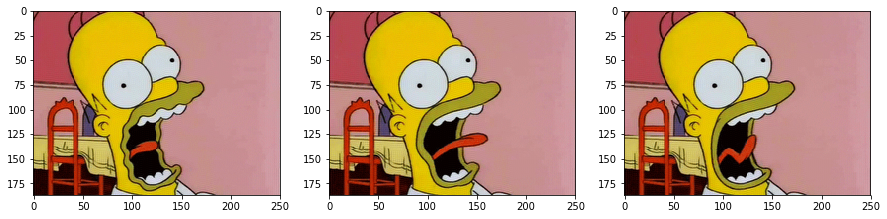

In [5]:
Tiff_show('/Users/zhouhang/Project/Chirp-EE123/asset/simpson/')

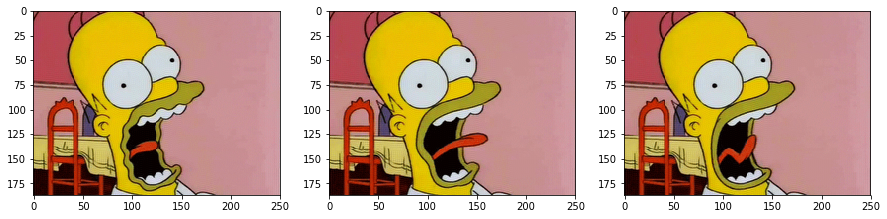

In [6]:
npArray_show(pixData)

In [7]:
# Tiff_play('/Users/zhouhang/Project/Chirp-EE123/asset/Andy_Video/', 1000)
npArray_play(pixData, frame_rate = 20)

In [232]:
def downsample(npArray, factor_xy, timeFlag = False):
    """
    Params:
    timeFlag: whether or not downsample in t index, False by default
    factor_xy: only support float, if wrong type, use 100% by default. 
    
    Notice:
    If you want to use 100%, use 1.0 instead of 1!!
    we only support resample by 2 on time axis!!
    
    """
    if type(factor_xy) is not float:
        print("wrong sampling rate format!!!, continue with factor_xy = 1")
        factor_xy = 1.0
    
    if len(npArray.shape) == 3:
        ori_height= npArray.shape[0]
        ori_width = npArray.shape[1]
        ori_channels = npArray.shape[2]
        timeFlag = False
    else:
        ori_frames = npArray.shape[0]
        ori_height= npArray.shape[1]
        ori_width = npArray.shape[2]
        ori_channels = npArray.shape[3]
        
    
    height = int(ori_height*factor_xy)
    width = int(ori_width*factor_xy)

        
    data_xy = np.empty([ori_frames, height, width, ori_channels], dtype = 'uint8')
    for i in range(ori_frames):
        data_xy[i] = misc.imresize(npArray[i], factor_xy)
    
    
    
    # time axis
    if timeFlag:
        # downsample
        h_t = signal.firwin(ori_frames, 1/2)
        ndimage.convolve1d(data_xy, h_t, axis = 0)

        new_frames = int(np.ceil(ori_frames/2))
        data_t = np.empty([new_frames, height, width, ori_channels], dtype = 'uint8')

        for i in range(ori_frames):
            if i%2 == 0: 
                data_t[i//2] = data_xy[i]
        result = data_t
        frames = new_frames
    else:
        result = data_xy
        frames = ori_frames
        
    # actually encode the data into bitarray file. 
#     origin_info = {
#         'height':ori_height,
#         'width':ori_width,
#         'frames':ori_frames,
#         'channels':ori_channels,
#         'timeFlag':timeFlag
#     }
    
    origin_info = [ori_height, ori_width, ori_frames, ori_channels]
    compressed_info = [timeFlag, height, width, frames, ori_channels]
    info = origin_info+compressed_info
    
    return result, info

In [233]:
def upsample(npArray, info):
    """    
    origin_info: list
    """
    frames = npArray.shape[0]
    height= npArray.shape[1]
    width = npArray.shape[2]
    channels = npArray.shape[3]
        
    ori_height = info[0]
    ori_width = info[1]
    ori_frames = info[2]
    ori_channels = info[3]
    timeFlag = info[4]
    
        
        
        
    data_t = np.empty([ori_frames, height, width, ori_channels], dtype = 'uint8')
    # time axis recover first
    if timeFlag:
            # upsample
            for i in range(ori_frames):
                if i%2 == 0:
                    data_t[i] = npArray[i//2]
                else:
                    data_t[i] = np.zeros([height, width, channels], dtype = 'uint8')
            
            # interpolate
#             h_i = np.kaiser(10, 9)
#             idx = np.linspae()
#             ndimage.convolve1d(data_t, h_i, axis = 0)
            data_t = signal.resample(data_t, ori_frames, axis = 0, )
#             data_t = interpolate.interp1d(h, data_t, axis = 0)
            
    else:
        data_t = npArray
                
    # xy axis recover
    result = np.empty([ori_frames, ori_height, ori_width, ori_channels], dtype = 'uint8')
    for i in range(ori_frames):
        result[i] = misc.imresize(data_t[i], [ori_height, ori_width])
    
    return result

In [40]:
ori_height = info[0].item()
ori_width = info[1]
ori_channels = info[2]
ori_frames = info[3]
timeFlag = info[4]

info[0] = 2000
print(info)
type(ori_height)
print(ori_height.bit_length())
key = bytes(info)
print(key)
print(type(key))
print(len(key))





[2000  250    3    3    0]
11
b'\xd0\x07\x00\x00\x00\x00\x00\x00\xfa\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'
<class 'bytes'>
40


In [95]:
new_key = int_to_bytes(10000)
a = 1000
print(a.bit_length())
r_k = int_from_bytes(new_key)
print(r_k)
print(key+new_key)

10
10000
b"\xd0\x07\x00\x00\x00\x00\x00\x00\xfa\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00'\x10"


In [116]:
f = open('/Users/zhouhang/Project/Chirp-EE123/asset/Andy_Video/frame_01.tiff', 'rb')
b = f.read(100)
print(b)
f.close()

b'II*\x00\r\x1b\x03\x00~\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc\xce\xbb\xdc'


In [170]:
sys.byteorder
a = [1,2,3]
a[1:2]

[2]

In [45]:
def int_to_bytes(x):
    return x.to_bytes((x.bit_length() + 7) // 8, 'big')

def int_from_bytes(xbytes):
    return int.from_bytes(xbytes, 'big')

In [222]:
def encode(info, bodyData):
    """
    to save the trouble from python bitstream, we'll use file as the buffer for transmission
    """
    filename = asset_path + 'buffer.txt'
    with open(filename, 'bw+') as f_buffer:
        # encode the origin_info
        new_info = [len(info)] + info
        header = pack('%si' % len(new_info), *new_info)
        print(header)
        print(type(header))
        print(len(header))

        # flatten the numpy array and encode 
        dataVec = bodyData.tolist()
        body_header = pack('i', len(dataVec))
        # Judge if the len need to use long
        body = body_header + pack('%si' % len(dataVec), *dataVec)
        print(type(body))
        print(len(body))       
        f_buffer.write(header+body)

def decode():
    filename = asset_path + 'buffer.txt'
    with open(filename, 'rb') as f_buffer:
        data = f_buffer.read()
        print(type(data))
        print(len(data))
        # decode the origin_info
        header_len = unpack('i', data[0:4])
        print(header_len[0])
        header_end_idx = 4*header_len[0]+4
        info = unpack('%si' % (header_len[0]), data[4: header_end_idx])
        # decode body
        body_start_idx = header_end_idx
        body_len = unpack('i', data[body_start_idx: body_start_idx + 4])
        bodyData = np.array(unpack('%si' % (body_len[0]), data[body_start_idx + 4:]))
    return info, bodyData
    
    

In [237]:
encode(info, r.flatten())
inf, bodyDat = decode()

com_height = inf[5]
com_width = inf[6]
com_channels = inf[7]
com_frames = inf[8]
recons = upsample(bodyDat.reshape(com_frames, com_height, com_width, com_channels), inf)
npArray_play(recons, frame_rate = 20)
# print(bodyDat.shape)
# ori_height = inf[0]
# ori_width = inf[1]
# ori_channels = inf[2]
# ori_frames = inf[3]
# timeFlag = inf[4]

# npArray_show(bodyDat.reshape(ori_frames, ori_height, ori_width, ori_channels))

b'\t\x00\x00\x00\xbb\x00\x00\x00\xfa\x00\x00\x00\x03\x00\x00\x00\x03\x00\x00\x00\x00\x00\x00\x00]\x00\x00\x00}\x00\x00\x00\x03\x00\x00\x00\x03\x00\x00\x00'
<class 'bytes'>
40
<class 'bytes'>
418504
<class 'bytes'>
418544
9
40


/Users/zhouhang/anaconda3/envs/dsp/lib/python3.5/site-packages/ipykernel/__main__.py:42: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [169]:
a = np.random.rand(2,3,4,5)
# print(a)
b = a.flatten()
print(b.shape)
c = b.reshape(2,3,4,5)
# print(c)
print(a == c)

(120,)
[[[[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]

  [[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]

  [[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]]


 [[[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]

  [[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]

  [[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True  True  True]]]]


In [234]:
r, info= downsample(pixData, 0.5)
print(info)
npArray_play(r, frame_rate = 20)

[187, 250, 3, 3, False, 93, 125, 3, 3]


/Users/zhouhang/anaconda3/envs/dsp/lib/python3.5/site-packages/ipykernel/__main__.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


In [235]:
recon = upsample(r, info)
npArray_play(recon, frame_rate = 20)

/Users/zhouhang/anaconda3/envs/dsp/lib/python3.5/site-packages/ipykernel/__main__.py:42: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


## Evaluation

In [18]:
PSNR = psnr(pixData, recon)
print("psnr of comression: %.4f" % PSNR)

psnr of comression: 24.3867
